En data.py se cargan los datos y se dividen en _train_ y _test_ aleatoriamente (fijando una semilla).

In [3]:
from data import X_train, X_test, y_train, y_test
import numpy as np

print("Proporción datos train: ", np.round(np.size(y_train)/(np.size(y_train)+np.size(y_test)), 2))
print("Proporción datos test: ", np.round(np.size(y_test)/(np.size(y_train)+np.size(y_test)), 2))

Proporción datos train:  0.8
Proporción datos test:  0.2


En tree.py se implementa el árbol de decisión bajo la clase _CART_, la cual toma como parámetros:
* _max_depth_, profunidad máxima del árbol;
* _min_samples_split_, cantidad mínima de muestras que tienen que haber para hacer un split; y
* _min_samples_leaf_, cantidad mínima de muestras que pueden quedar en una hoja después de un split.

In [4]:
from tree import CART, print_tree

tree = CART(max_depth=5, min_samples_split=5, min_samples_leaf=2)
tree.fit(X_train, y_train)

y_pred = tree.predict(X_train)
accuracy = np.mean(y_pred == y_train)

print("Accuracy (en train):", accuracy)
print_tree(tree.tree) # Función para imprimir el árbol

Accuracy (en train): 0.978021978021978
Node d=0 samples=455 gini=0.4635 pred=0 feat=27 thr=0.14235
  Node d=1 samples=305 gini=0.1505 pred=0 feat=20 thr=16.805
    Node d=2 samples=278 gini=0.0491 pred=0 feat=None thr=None
    Node d=2 samples=27 gini=0.4444 pred=1 feat=1 thr=16.375
      Node d=3 samples=7 gini=0.0000 pred=0 feat=None thr=None
      Node d=3 samples=20 gini=0.1800 pred=1 feat=None thr=None
  Node d=1 samples=150 gini=0.1128 pred=1 feat=13 thr=13.93
    Node d=2 samples=3 gini=0.0000 pred=0 feat=None thr=None
    Node d=2 samples=147 gini=0.0783 pred=1 feat=16 thr=0.13565
      Node d=3 samples=145 gini=0.0537 pred=1 feat=6 thr=0.08635000000000001
        Node d=4 samples=10 gini=0.4800 pred=1 feat=5 thr=0.095025
          Node d=5 samples=5 gini=0.0000 pred=1 feat=None thr=None
          Node d=5 samples=5 gini=0.3200 pred=0 feat=None thr=None
        Node d=4 samples=135 gini=0.0000 pred=1 feat=None thr=None
      Node d=3 samples=2 gini=0.0000 pred=0 feat=None thr=N

Para hacer la validación cruzada se define una función _k-fold_ que particione el conjunto de entrenamiento en _k_ partes de composición aleatoria, destinándose una de ellas a la validación y las _k-1_ restantes al entrenamiento.

In [3]:
def k_fold_cross_validation(X, y, k=5, max_depth=None, min_samples_split=2, min_samples_leaf=1, seed=40):
    n_samples = len(y)
    indices = np.arange(n_samples)
    np.random.seed(seed)
    np.random.shuffle(indices)  # Mezclar datos

    fold_sizes = np.full(k, n_samples // k, dtype=int)
    fold_sizes[: n_samples % k] += 1  # Repartir sobrantes
    current = 0

    scores_val = []
    scores_train = []

    for fold_size in fold_sizes:
        start, stop = current, current + fold_size
        val_idx = indices[start:stop]
        train_idx = np.concatenate((indices[:start], indices[stop:]))

        X_train_fold, y_train_fold = X[train_idx], y[train_idx]
        X_val_fold, y_val_fold = X[val_idx], y[val_idx]

        # Entrenar árbol
        tree = CART(max_depth=max_depth, min_samples_leaf=min_samples_leaf, min_samples_split=min_samples_split)
        tree.fit(X_train_fold, y_train_fold)

        # Predecir en entrenamiento y validación
        y_pred_val = tree.predict(X_val_fold)
        y_pred_train = tree.predict(X_train_fold)
        acc_val = np.mean(y_pred_val == y_val_fold)
        acc_train = np.mean(y_pred_train == y_train_fold)
        scores_val.append(acc_val)
        scores_train.append(acc_train)

        current = stop

    return scores_train, scores_val

In [4]:
scores_train, scores_val = k_fold_cross_validation(X_train, y_train, k=5, max_depth=10, min_samples_split=5, min_samples_leaf=2)

print("Accuracies entrenamiento:", np.round(scores_train, 3))
print("Accuracies validación:", np.round(scores_val,3))
print("Accuracy entrenamiento = ", np.round(np.mean(scores_train),3), "±", np.round(np.std(scores_train),3))
print("Accuracy validación = ", np.round(np.mean(scores_val),3), "±", np.round(np.std(scores_val),3))

Accuracies entrenamiento: [0.981 0.984 0.989 0.97  0.989]
Accuracies validación: [0.967 0.923 0.923 0.956 0.923]
Accuracy entrenamiento =  0.982 ± 0.007
Accuracy validación =  0.938 ± 0.019


Se observa que para las 5 particiones las accuracies de la validación son menores a las del entrenamiento, como es de esperar. Sin embargo no parece haber un gap demasiado grande entre ambas accuracies, incluso las accuracies del entrenamiento tampoco son exactamente 1, con lo cual pareciera que el árbol no está "memorizando" los datos de entrenamiento y está teniendo una buena capacidad de generalización.

Se puede estudiar este compromiso entre memorización y generalización entrenando al árbol con distintos tamaños del dataset de entrenamiento y viendo cómo evolucionan las accuracies del entrenamiento y de la validación:

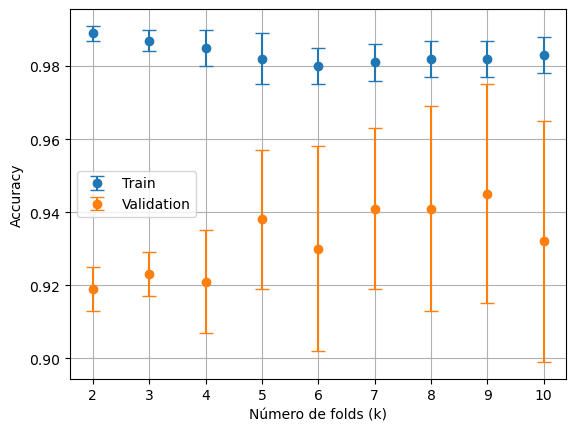

In [6]:
import matplotlib.pyplot as plt

train = []
val = []
desvtrain = []
desvval = []

k_values = list(range(2,11))

for i in k_values:
    scores_train, scores_val = k_fold_cross_validation(X_train, y_train, k=i, max_depth=10, min_samples_split=5, min_samples_leaf=2)
    train.append(np.round(np.mean(scores_train),3))
    val.append(np.round(np.mean(scores_val),3))
    desvtrain.append(np.round(np.std(scores_train),3))
    desvval.append(np.round(np.std(scores_val),3))

plt.errorbar(k_values, train, yerr=desvtrain, fmt="o", capsize=5, label="Train")
plt.errorbar(k_values, val, yerr=desvval, fmt="o", capsize=5, label="Validation")
plt.xlabel("Número de folds (k)")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

Se observa cómo un 5-fold es una buena elección para maximizar las accuracies de ambos conjuntos sin que el desvío estándar sea demasiado alto (como ocurre para los 7,8 y 9-folds).